In [45]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from py_vollib import black_scholes_merton as bsm

In [46]:
class FiniteDifferences(object):

    def __init__(self, S0, K, r, T, sigma, Smax, M, N,
                 is_call=True):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.Smax = Smax
        self.M, self.N = int(M), int(N)  # Ensure M&N are integers
        self.is_call = is_call
        
        # calculate the discretization size of the space(price) and time
        self.dS = Smax / float(self.M)
        self.dt = T / float(self.N)
        
        # create index list
        self.i_values = np.arange(self.M)
        self.j_values = np.arange(self.N)
        
        # save all the option price at each step into a 2-D matrix
        self.grid = np.zeros(shape=(self.M+1, self.N+1))
        
        # manipulate the asset price when the discretize step
        self.boundary_conds = np.linspace(0, Smax, self.M+1)

    def _setup_boundary_conditions_(self):
        pass

    def _setup_coefficients_(self):
        pass

    def _traverse_grid_(self):
        """  Iterate the grid forward in time """
        pass

    def _interpolate_(self):
        """
        Use piecewise linear interpolation on the initial
        grid column to get the closest price at S0.
        """
        # return np.interp(self.S0, 
        #                  self.boundary_conds,
        #                  self.grid[:, -1])
        return np.interp(self.S0, 
                         self.boundary_conds,
                         self.grid[:, 0])
        
    def price(self):
        self._setup_boundary_conditions_()
        self._setup_coefficients_()
        self._traverse_grid_()
        return self._interpolate_()
    
    def print_grid(self):
        possible_prices = {}
        for j in self.j_values:
            tmp  = []
            for i in range(self.M):
                tmp.append(self.grid[i, j])
                pass
            possible_prices[j] = tmp
        return possible_prices
    
    def get_info(self):
        infos = {}
        for j in self.j_values:
            tmp  = []
            for i in range(self.M)[:]:
                info = {'asset': i*self.dS, 'time': j*self.dt, 'option': self.grid[i, j]}
                tmp.append(info)
                pass
            infos[j] = tmp
        return infos

In [47]:
""" Explicit method of Finite Differences using backward differenciation for time """
class FDExplicitEu(FiniteDifferences):

    def _setup_boundary_conditions_(self):
        if self.is_call:
            self.grid[:, -1] = np.maximum(
                self.boundary_conds - self.K, 0)
            self.grid[-1, :-1] = (self.Smax - self.K) * \
                                 np.exp(-self.r *
                                        self.dt *
                                        (self.N-self.j_values))
        else:
            self.grid[:, -1] = \
                np.maximum(self.K-self.boundary_conds, 0)
            self.grid[0, :-1] = (self.K - self.Smax) * \
                               np.exp(-self.r *
                                      self.dt *
                                      (self.N-self.j_values))

    def _setup_coefficients_(self):
        self.a = 0.5 * self.dt * ((self.sigma**2) *
                              (self.i_values**2) -
                              self.r*self.i_values)
        self.b = 1 - self.dt * ((self.sigma**2) * 
                              (self.i_values**2) + 
                              self.r)
        self.c = 0.5 * self.dt * ((self.sigma**2) * 
                              (self.i_values**2) + 
                              self.r*self.i_values)

    def _traverse_grid_(self):
        for j in reversed(self.j_values):
            for i in range(self.M)[:]:
                self.grid[i,j] = self.a[i] * self.grid[i-1,j+1] +\
                                 self.b[i] * self.grid[i,j+1] + \
                                 self.c[i] * self.grid[i+1,j+1] 

# Call

In [61]:
option = FDExplicitEu(S0=50, K=50, r =0.1, T=1.0, sigma = 0.4, Smax=100, M=200, N=10000, is_call=True)
print(option.price())

test_price = (bsm.black_scholes_merton(flag = 'c', S = 50, K = 50, q = 0, t = 1.0, r = 0.1, sigma = 0.4))
print(test_price)

prices = option.print_grid()
print(len(prices))

# print(option.boundary_conds)
print(option.grid[-1, :-1])

info = option.get_info()
print(len(info))
print(info[100][-1])
print(info[5000][-1])
print(info[9999][-1])
print(info[9999][1])
print(info[9999][0])

9.909575362261545
10.159234655029346
10000
[45.2418709  45.24232332 45.24277575 ... 49.99850002 49.99900001
 49.9995    ]
10000
{'asset': 99.5, 'time': 0.01, 'option': 44.98649645551197}
{'asset': 99.5, 'time': 0.5, 'option': 47.1988372630977}
{'asset': 99.5, 'time': 0.9999, 'option': 49.5005}
{'asset': 0.5, 'time': 0.9999, 'option': 0.0}
{'asset': 0.0, 'time': 0.9999, 'option': 0.0}


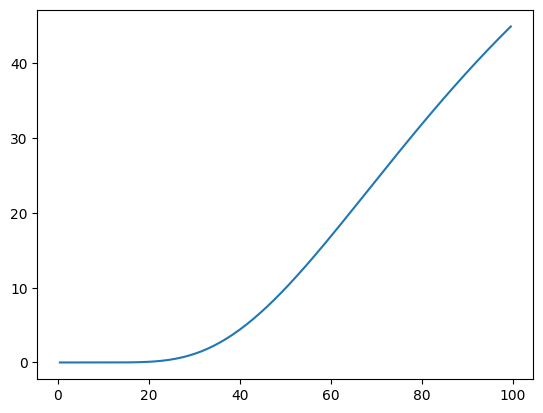

{'asset': 50.0, 'time': 0.0001, 'option': 9.909062266034327}
{'asset': 49.5, 'time': 0.0001, 'option': 9.5909270796347}
{'asset': 99.5, 'time': 0.0001, 'option': 44.942756339081186}
44.64132642922059
44.942314713511955
44.942756339081186
45.242323322769096
-----------------------------------------
44.64175719629871
44.942756339081186
44.94319796852619
45.24277574826445
-----------------------------------------
49.000499999999995
49.5006821927945
49.5005
49.99950000249999
-----------------------------------------
49.0
49.5005
49.5
50.0
[{'asset': 0.0, 'time': 0.0001, 'option': 0.0}, {'asset': 0.5, 'time': 0.0001, 'option': 2.2417882260752356e-19}, {'asset': 1.0, 'time': 0.0001, 'option': 5.0456023116896167e-17}, {'asset': 1.5, 'time': 0.0001, 'option': 3.391305460650865e-15}, {'asset': 2.0, 'time': 0.0001, 'option': 1.0723537059078408e-13}, {'asset': 2.5, 'time': 0.0001, 'option': 1.964024547040515e-12}, {'asset': 3.0, 'time': 0.0001, 'option': 2.3585128106233176e-11}, {'asset': 3.5, 't

In [64]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info[1][i+1]['asset'])
    option_price.append(info[1][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info[1][100])
print(info[1][99])
print(info[1][-1])

print(option.grid[198, 1])
print(option.grid[199, 0])
print(option.grid[199, 1])
print(option.grid[200, 1])
print('-----------------------------------------')
print(option.grid[198, 2])
print(option.grid[199, 1])
print(option.grid[199, 2])
print(option.grid[200, 2])
print('-----------------------------------------')
print(option.grid[198, -2])
print(option.grid[199, -3])
print(option.grid[199, -2])
print(option.grid[200, -2])
print('-----------------------------------------')
print(option.grid[198, -1])
print(option.grid[199, -2])
print(option.grid[199, -1])
print(option.grid[200, -1])

print(info[1])

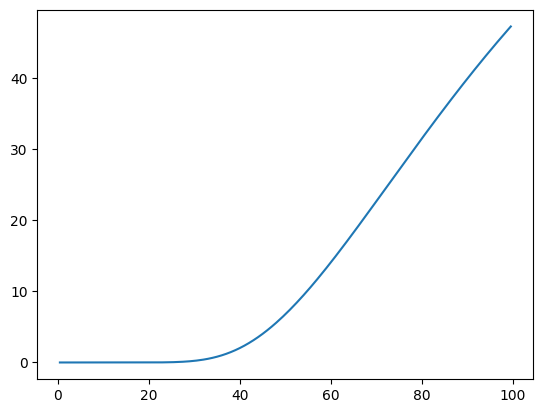

{'asset': 5.0, 'time': 0.5, 'option': 7.840481758769566e-15}
[{'asset': 0.0, 'time': 0.5, 'option': 0.0}, {'asset': 0.5, 'time': 0.5, 'option': 9.043497441937276e-30}, {'asset': 1.0, 'time': 0.5, 'option': 5.675232409049699e-27}, {'asset': 1.5, 'time': 0.5, 'option': 1.0692679240880171e-24}, {'asset': 2.0, 'time': 0.5, 'option': 9.46141651407131e-23}, {'asset': 2.5, 'time': 0.5, 'option': 4.803437272127795e-21}, {'asset': 3.0, 'time': 0.5, 'option': 1.5713564486725682e-19}, {'asset': 3.5, 'time': 0.5, 'option': 3.5769045084866865e-18}, {'asset': 4.0, 'time': 0.5, 'option': 5.988312231578394e-17}, {'asset': 4.5, 'time': 0.5, 'option': 7.691975171806615e-16}, {'asset': 5.0, 'time': 0.5, 'option': 7.840481758769566e-15}, {'asset': 5.5, 'time': 0.5, 'option': 6.519934016800298e-14}, {'asset': 6.0, 'time': 0.5, 'option': 4.5273513606167253e-13}, {'asset': 6.5, 'time': 0.5, 'option': 2.6777982787830063e-12}, {'asset': 7.0, 'time': 0.5, 'option': 1.3724745060506389e-11}, {'asset': 7.5, 'time'

In [50]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info[5000][i+1]['asset'])
    option_price.append(info[5000][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info[5000][10])
print(info[5000])

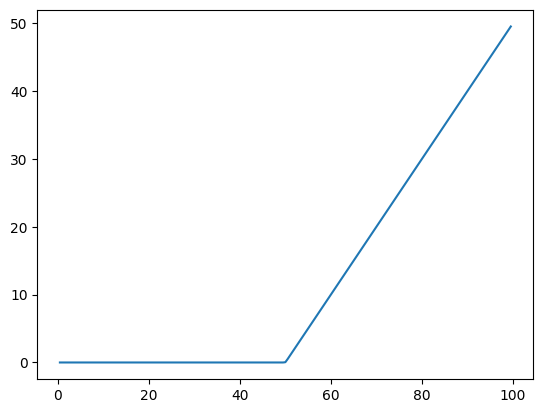

[{'asset': 0.0, 'time': 0.9999, 'option': 0.0}, {'asset': 0.5, 'time': 0.9999, 'option': 0.0}, {'asset': 1.0, 'time': 0.9999, 'option': 0.0}, {'asset': 1.5, 'time': 0.9999, 'option': 0.0}, {'asset': 2.0, 'time': 0.9999, 'option': 0.0}, {'asset': 2.5, 'time': 0.9999, 'option': 0.0}, {'asset': 3.0, 'time': 0.9999, 'option': 0.0}, {'asset': 3.5, 'time': 0.9999, 'option': 0.0}, {'asset': 4.0, 'time': 0.9999, 'option': 0.0}, {'asset': 4.5, 'time': 0.9999, 'option': 0.0}, {'asset': 5.0, 'time': 0.9999, 'option': 0.0}, {'asset': 5.5, 'time': 0.9999, 'option': 0.0}, {'asset': 6.0, 'time': 0.9999, 'option': 0.0}, {'asset': 6.5, 'time': 0.9999, 'option': 0.0}, {'asset': 7.0, 'time': 0.9999, 'option': 0.0}, {'asset': 7.5, 'time': 0.9999, 'option': 0.0}, {'asset': 8.0, 'time': 0.9999, 'option': 0.0}, {'asset': 8.5, 'time': 0.9999, 'option': 0.0}, {'asset': 9.0, 'time': 0.9999, 'option': 0.0}, {'asset': 9.5, 'time': 0.9999, 'option': 0.0}, {'asset': 10.0, 'time': 0.9999, 'option': 0.0}, {'asset': 1

In [51]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info[9999][i+1]['asset'])
    option_price.append(info[9999][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info[9999])

# Put

In [52]:
option1 = FDExplicitEu(50, 50, 0.1, 1.0, 0.4, 100, 200, 10000, False)
print(option1.price())

test_price = (bsm.black_scholes_merton(flag = 'p', S = 50, K = 50, q = 0, t = 1.0, r = 0.1, sigma = 0.4))
print(test_price)

prices = option1.print_grid()
# print(len(prices))

info1 = option1.get_info()
print(len(info1))

print(info1[100][10])
print(info1[5000][10])
print(info1[9999][10])

print(option.grid[-1, 1])
print(option.grid[199, 1])
print(option.grid[200, 1])

5.39954594518403
5.401105556827323
10000
{'asset': 5.0, 'time': 0.01, 'option': 40.287113008576284}
{'asset': 5.0, 'time': 0.5, 'option': 42.56145933458922}
{'asset': 5.0, 'time': 0.9999, 'option': 44.9995}
45.242323322769096
44.942756339081186
45.242323322769096


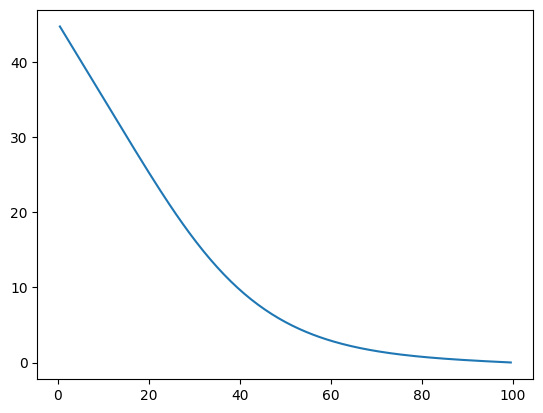

{'asset': 50.5, 'time': 0.0001, 'option': 5.238355982972948}
{'asset': 50.0, 'time': 0.0001, 'option': 5.399403339841244}
{'asset': 49.5, 'time': 0.0001, 'option': 5.564949397754239}
[{'asset': 0.0, 'time': 0.0001, 'option': 45.24230070374481}, {'asset': 0.5, 'time': 0.0001, 'option': 44.74230070373668}, {'asset': 1.0, 'time': 0.0001, 'option': 44.242300703720645}, {'asset': 1.5, 'time': 0.0001, 'option': 43.7423007037273}, {'asset': 2.0, 'time': 0.0001, 'option': 43.24230070372727}, {'asset': 2.5, 'time': 0.0001, 'option': 42.74230070372753}, {'asset': 3.0, 'time': 0.0001, 'option': 42.24230070375327}, {'asset': 3.5, 'time': 0.0001, 'option': 41.742300703932706}, {'asset': 4.0, 'time': 0.0001, 'option': 41.24230070504221}, {'asset': 4.5, 'time': 0.0001, 'option': 40.74230071053044}, {'asset': 5.0, 'time': 0.0001, 'option': 40.24230073286598}, {'asset': 5.5, 'time': 0.0001, 'option': 39.74230081006877}, {'asset': 6.0, 'time': 0.0001, 'option': 39.2423010426287}, {'asset': 6.5, 'time': 

In [53]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info1[1][i+1]['asset'])
    option_price.append(info1[1][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info1[1][101])
print(info1[1][100])
print(info1[1][99])
print(info1[1])

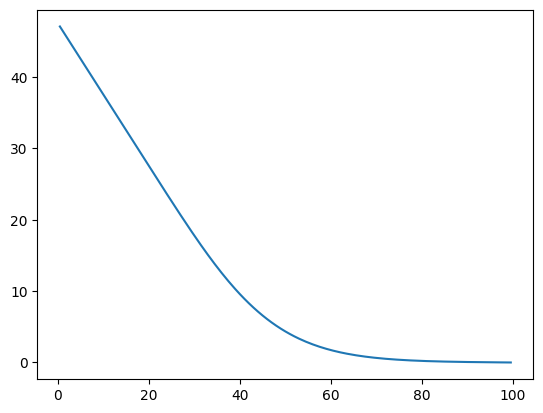

{'asset': 5.0, 'time': 0.5, 'option': 42.56145933458922}
[{'asset': 0.0, 'time': 0.5, 'option': 47.56145933460081}, {'asset': 0.5, 'time': 0.5, 'option': 47.06145933459696}, {'asset': 1.0, 'time': 0.5, 'option': 46.56145933458737}, {'asset': 1.5, 'time': 0.5, 'option': 46.06145933459243}, {'asset': 2.0, 'time': 0.5, 'option': 45.56145933459185}, {'asset': 2.5, 'time': 0.5, 'option': 45.06145933458991}, {'asset': 3.0, 'time': 0.5, 'option': 44.561459334593614}, {'asset': 3.5, 'time': 0.5, 'option': 44.06145933459454}, {'asset': 4.0, 'time': 0.5, 'option': 43.561459334592406}, {'asset': 4.5, 'time': 0.5, 'option': 43.06145933458954}, {'asset': 5.0, 'time': 0.5, 'option': 42.56145933458922}, {'asset': 5.5, 'time': 0.5, 'option': 42.061459334588754}, {'asset': 6.0, 'time': 0.5, 'option': 41.56145933458869}, {'asset': 6.5, 'time': 0.5, 'option': 41.06145933459145}, {'asset': 7.0, 'time': 0.5, 'option': 40.561459334602624}, {'asset': 7.5, 'time': 0.5, 'option': 40.06145933465005}, {'asset': 

In [54]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info1[5000][i+1]['asset'])
    option_price.append(info1[5000][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info1[5000][10])
print(info1[5000])

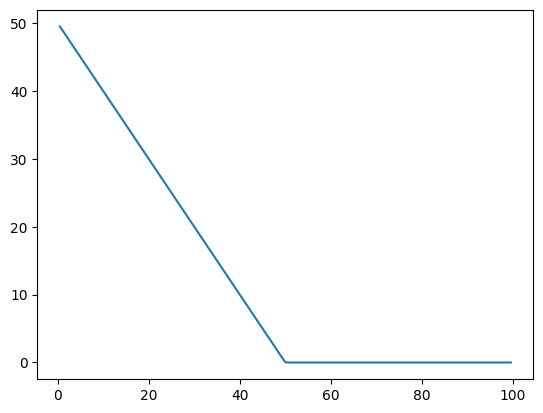

{'asset': 5.0, 'time': 0.9999, 'option': 44.9995}
[{'asset': 0.0, 'time': 0.9999, 'option': 49.999500000000005}, {'asset': 0.5, 'time': 0.9999, 'option': 49.4995}, {'asset': 1.0, 'time': 0.9999, 'option': 48.9995}, {'asset': 1.5, 'time': 0.9999, 'option': 48.4995}, {'asset': 2.0, 'time': 0.9999, 'option': 47.9995}, {'asset': 2.5, 'time': 0.9999, 'option': 47.499500000000005}, {'asset': 3.0, 'time': 0.9999, 'option': 46.999500000000005}, {'asset': 3.5, 'time': 0.9999, 'option': 46.4995}, {'asset': 4.0, 'time': 0.9999, 'option': 45.9995}, {'asset': 4.5, 'time': 0.9999, 'option': 45.4995}, {'asset': 5.0, 'time': 0.9999, 'option': 44.9995}, {'asset': 5.5, 'time': 0.9999, 'option': 44.499500000000005}, {'asset': 6.0, 'time': 0.9999, 'option': 43.999500000000005}, {'asset': 6.5, 'time': 0.9999, 'option': 43.4995}, {'asset': 7.0, 'time': 0.9999, 'option': 42.9995}, {'asset': 7.5, 'time': 0.9999, 'option': 42.4995}, {'asset': 8.0, 'time': 0.9999, 'option': 41.999500000000005}, {'asset': 8.5, '

In [55]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info1[9999][i+1]['asset'])
    option_price.append(info1[9999][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info1[9999][10])
print(info1[9999])